In [2]:
from preprocessing import vocab_size, add_start_stop
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from IPython.display import clear_output
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import seaborn as sns
import numpy as np
import pickle

### Import the Data

In [3]:
with open('./data/train_preprocessed_routes', 'rb') as f:
    X_train = pickle.load(f)['X']
with open('./data/test_preprocessed_routes', 'rb') as f:
    X_test = pickle.load(f)['X']
with open('./data/val_preprocessed_routes', 'rb') as f:
    X_val = pickle.load(f)['X']

In [7]:
X_train = np.apply_along_axis(add_start_stop, 1, X_train)
X_test = np.apply_along_axis(add_start_stop, 1, X_train)
X_val = np.apply_along_axis(add_start_stop, 1, X_train)

In [8]:
y_train = np.hstack((X_train[:, 1:], np.zeros((len(X_train), 1))))
y_test = np.hstack((X_test[:, 1:], np.zeros((len(X_test), 1))))
y_val = np.hstack((X_val[:, 1:], np.zeros((len(X_val), 1))))

### Model Definition

In [10]:
def positional_encoding(length, depth):
    depth = depth/2

    positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

    angle_rates = 1 / (10000**depths)         # (1, depth)
    angle_rads = positions * angle_rates      # (pos, depth)

    pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1) 

    return tf.cast(pos_encoding, dtype=tf.float32)

In [11]:
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) 
        self.pos_encoding = positional_encoding(length=2048, depth=d_model)

    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):
        length = tf.shape(x)[1]
        x = self.embedding(x)
        # This factor sets the relative scale of the embedding and positonal_encoding.
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = x + self.pos_encoding[tf.newaxis, :length, :]
        return x

In [12]:
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

class CausalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x,
            use_causal_mask = True)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

In [13]:
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super().__init__()
        self.seq = tf.keras.Sequential([
          tf.keras.layers.Dense(dff, activation='relu'),
          tf.keras.layers.Dense(d_model),
          tf.keras.layers.Dropout(dropout_rate)
        ])
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x) 
        return x

In [14]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
        super(DecoderLayer, self).__init__()

        self.causal_self_attention = CausalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.ffn = FeedForward(d_model, dff)

    def call(self, x):
        x = self.causal_self_attention(x=x)

        x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
        return x

In [15]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                                 d_model=d_model)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.dec_layers = [
            DecoderLayer(d_model=d_model, num_heads=num_heads,
                         dff=dff, dropout_rate=dropout_rate)
            for _ in range(num_layers)]

        self.last_attn_scores = None

    def call(self, x):
        # `x` is token-IDs shape (batch, target_seq_len)
        x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

        x = self.dropout(x)

        for i in range(self.num_layers):
            x  = self.dec_layers[i](x)

        # The shape of x is (batch_size, target_seq_len, d_model).
        return x

In [16]:
class DecoderGenerator(tf.keras.Model):
    def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size, dropout_rate=0.1):
        super().__init__()
        
        self.decoder = Decoder(num_layers=num_layers, d_model=d_model, num_heads=num_heads, dff=dff, vocab_size=vocab_size, dropout_rate=dropout_rate)
        self.final_layer = tf.keras.layers.Dense(vocab_size, activation='softmax')

    def call(self, x):
        x = self.decoder(x)
        logits = self.final_layer(x)

        try:
            del logits._keras_mask
        except AttributeError:
            pass

        return logits

In [17]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [18]:
def masked_loss(label, pred):
    mask = label != 0
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=False, reduction='none')
    loss = loss_object(label, pred)

    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask

    loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
    return loss

def masked_accuracy(label, pred):
    pred = tf.argmax(pred, axis=2)
    label = tf.cast(label, pred.dtype)
    match = label == pred

    mask = label != 0

    match = match & mask

    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

### Model Training

In [24]:
num_layers = 8
d_model = 128
dff = 512
num_heads = 4
dropout_rate = 0.1
epochs = 100
batch_size = 64

In [25]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)

In [26]:
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

In [27]:
model = DecoderGenerator(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    vocab_size=vocab_size
)

In [28]:
model.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy]
)

In [46]:
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset
)

Epoch 1/100
298/298 [==============================] - 14s 46ms/step - loss: 1.0297 - masked_accuracy: 0.6899 - val_loss: 4.5019 - val_masked_accuracy: 0.5705
Epoch 2/100
298/298 [==============================] - 14s 46ms/step - loss: 1.0292 - masked_accuracy: 0.6897 - val_loss: 4.5886 - val_masked_accuracy: 0.5554
Epoch 3/100
298/298 [==============================] - 14s 46ms/step - loss: 1.0283 - masked_accuracy: 0.6900 - val_loss: 5.8389 - val_masked_accuracy: 0.3856
Epoch 4/100
298/298 [==============================] - 14s 46ms/step - loss: 1.0239 - masked_accuracy: 0.6906 - val_loss: 4.4390 - val_masked_accuracy: 0.5707
Epoch 5/100
298/298 [==============================] - 14s 46ms/step - loss: 1.0197 - masked_accuracy: 0.6925 - val_loss: 4.6178 - val_masked_accuracy: 0.5424
Epoch 6/100
298/298 [==============================] - 14s 46ms/step - loss: 1.0199 - masked_accuracy: 0.6920 - val_loss: 4.5740 - val_masked_accuracy: 0.5566
Epoch 7/100
298/298 [=========================

### Training Plots

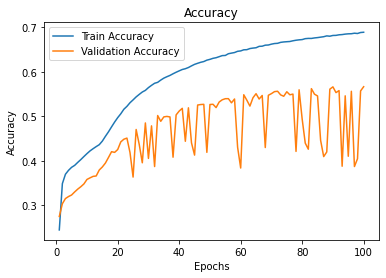

In [30]:
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(range(1, epochs+1), history.history['masked_accuracy'], label='Train Accuracy')
plt.plot(range(1, epochs+1), history.history['val_masked_accuracy'], label='Validation Accuracy')
plt.legend()

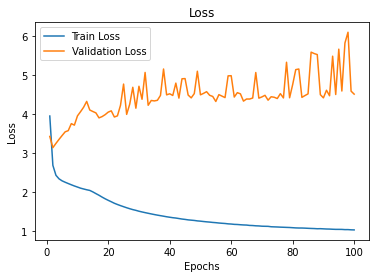

In [31]:
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(range(1, epochs+1), history.history['loss'], label='Train Loss')
plt.plot(range(1, epochs+1), history.history['val_loss'], label='Validation Loss')
plt.legend()

In [32]:
from preprocessing import *

In [33]:
test_route = ['V5', '40°', 'FFHSO']
test_route = list(map(lambda s: hold_to_idx[s], test_route))
test_route = [1] + test_route
l = len(test_route)
test_route += [0]*(22-l)

In [34]:
test_route

[1, 13, 5, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [40]:
def create_route(initial_sequence) -> list:
    route = initial_sequence.copy()
    for i in tf.range(np.argmin(initial_sequence)-1, len(initial_sequence)-1):
        predictions = model.predict([route])
        predictions = predictions[:, -1:, :]
        predicted_id = np.argmax(predictions, axis=-1)
        route[i+1] = predicted_id[0][0]
        
        if predicted_id == 3:
            break
            
    return route

In [41]:
create_route(test_route)

1/1 [==============================] - 0s 45ms/step


[1,
 13,
 5,
 7,
 166,
 143,
 143,
 58,
 58,
 58,
 58,
 58,
 76,
 76,
 76,
 76,
 76,
 76,
 145,
 76,
 76,
 141]